In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.6.0


In [3]:

import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.691776643999674
GPU (s):
0.04573788700008663
GPU speedup over CPU: 80x


In [4]:
#os.removedirs("train/.ipynb_checkpoints")

In [5]:
 for gender in os.listdir("train/"):
    print(str(len(os.listdir("train/" + gender))) + " " + gender + " images")

for gender in os.listdir("test/"):
    print(str(len(os.listdir("test/" + gender))) + " " + gender + " images")

289 female images
285 male images
129 female images
130 male images


In [6]:
img_size = 64
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory("test",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 574 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


In [7]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(64, 64,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 3rd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       5

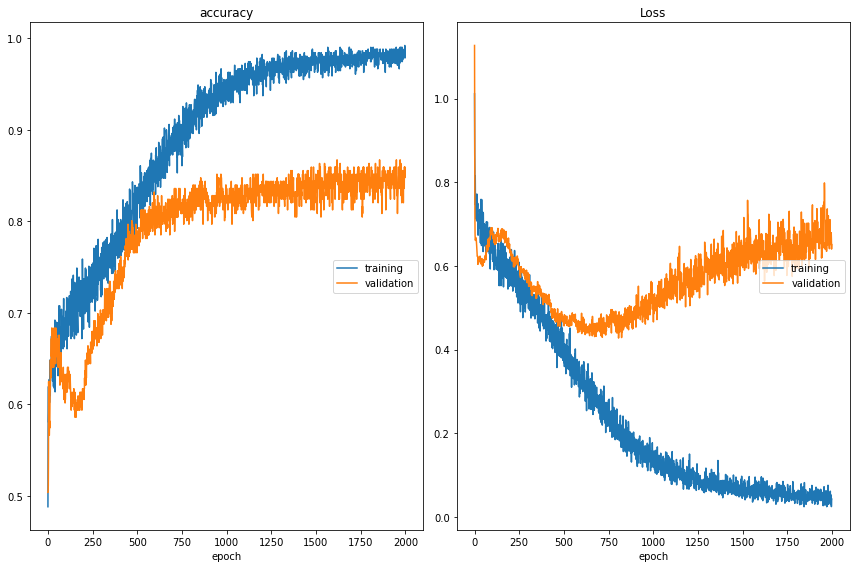

accuracy
	training         	 (min:    0.488, max:    0.992, cur:    0.988)
	validation       	 (min:    0.504, max:    0.918, cur:    0.895)
Loss
	training         	 (min:    0.024, max:    1.012, cur:    0.043)
	validation       	 (min:    0.428, max:    1.127, cur:    0.651)

Epoch 02000: saving model to models/gender_prediction.h5
CPU times: user 51min 10s, sys: 7min 5s, total: 58min 16s
Wall time: 1h 5min 57s


In [8]:
%%time

epochs = 2000
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("models/gender_prediction.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]
with tf.device('/device:GPU:0'):
  history = model.fit(
      x=train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps,
      callbacks=callbacks
  )

In [9]:
model_json = model.to_json()
with open("models/gender_model.json", "w") as json_file:
    json_file.write(model_json)

In [57]:
scores=[[20,27,16,23,20,27,18],
        [8,18,11,17,9,12,0],
        [34,19,25,22,19,25,31],
        [17,8,11,34,15,0,9],
        [2,0,3,0,10,2,0]]

def find_mode(x):
    x.sort(reverse=True); #sorting in descending order
    temp=[] #declaring a temeporary list
    s=list(set(x)) #removing duplicates
    s=s[::-1];#reversing our set

    x.append(" ");#for overcoming boundary case
    p=x[0];#fixing read to first element for matching
    count=0;#counting variable for repetition in data
    for i in x:
        if p!=i:
            temp.append(count);#appending count to a temp list
            count=0;#setting count to 0
            p=i;# previous to current
        count+=1;
     
    index=temp.index(max(temp))#getting index of maximum repeated element. 
    ret=[s[index]]# init of final list
    for i in range(1,len(temp)):
        if temp[index]==temp[i] and index!=i:
            ret.append(s[i]);#appending data to final list
    ret=ret[::-1]     #reversing for valid outcome
    return ret;

def find_player_mode(scores,p):

    return find_mode(scores[p]) #getting output from find_modes function.

def find_game_mode(scores,g):
    processed=[];
    for i in scores:
        processed.append(i[g])
    return find_mode(processed)

print("find_modes:",find_modes([1,2,3,4]))
print("find_player_modes:",find_player_mode(scores,0))
print("find_modes:",find_game_mode(scores,2))

find_modes: [1, 2, 3, 4]
find_player_modes: [20, 27]
find_modes: [25]
